# Traffic Prediction

Traffic congestion and related problems are a common concern in urban areas.  Understanding traffic patterns and analyzing data patterns can provide valuable insights for transportation planning, infrastructure development, and congestion management.

In this project, the goal is to analyze traffic flow data to identify patterns and predict traffic conditions.  

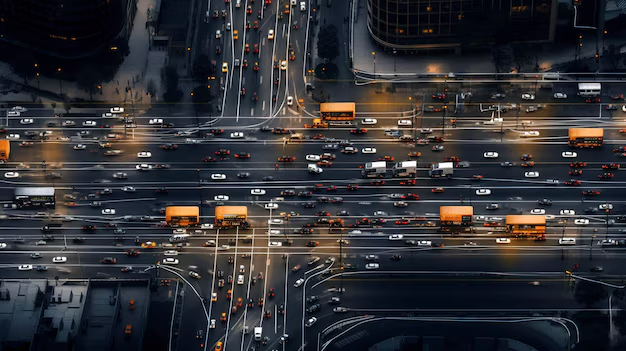

This dataset contains traffic data was collected by a computer vision model.  The model detects four classes of vehicles: cars, bikes, buses, and trucks.  The dataset includes the following columns:

- Time: Time of the record in HH:MM:SS
- Date: Day of the month
- Day of the week: Name of the day
- CarCount, BikeCount, BusCount, TruckCount: Counts of respective vehicles
- Total: Total count of all vehicle types detected within a 15-minute duration
- Traffic Situation: Categorized into four classes (1-Heavy, 2-High, 3-Normal, 4-Low)

## Import the Libraries 

In [56]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Importing the dataset

In [2]:
traffic_df = pd.read_csv('Traffic.csv')

traffic_df.head()

Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   

   TruckCount  Total Traffic Situation  
0           4     39               low  
1           3     55               low  
2           6     55               low  
3           5     58               low  
4          16     94            normal

### Check for Missing Values

There isn't any missing data.

In [3]:
traffic_df.isna().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

### Check for any duplicate records

There is also no duplicate records

In [4]:
traffic_df.duplicated().sum()

0

### Check the value counts

In [5]:
traffic_df['Traffic Situation'].value_counts()

normal    1669
heavy      682
high       321
low        304
Name: Traffic Situation, dtype: int64

### Initial thoughts

We have established that there isn't any missing values and no duplicate records in this dataset.  We can now explore the data in more detail. 

## Exploratory Data Analysis

In [6]:
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts", "Bike Counts", 
                                                    "Bus Counts", "Truck Counts"))
fig.add_trace(go.Histogram(x=traffic_df['CarCount'], name = 'Car Counts'), row=1, col=1)
fig.add_trace(go.Histogram(x=traffic_df['BikeCount'], name = 'Bike Counts'), row=1, col=2)
fig.add_trace(go.Histogram(x=traffic_df['BusCount'], name = 'Bus Counts'), row=2, col=1)
fig.add_trace(go.Histogram(x=traffic_df['TruckCount'], name = 'Truck Counts'), row=2, col=2)

fig.update_layout(title_text='Distribution of Vehicles', title_x=0.5, showlegend=False, 
                  template='plotly_white')
fig.update_xaxes(title_text='Count')
fig.update_yaxes(title_text='Frequency')
fig.show()

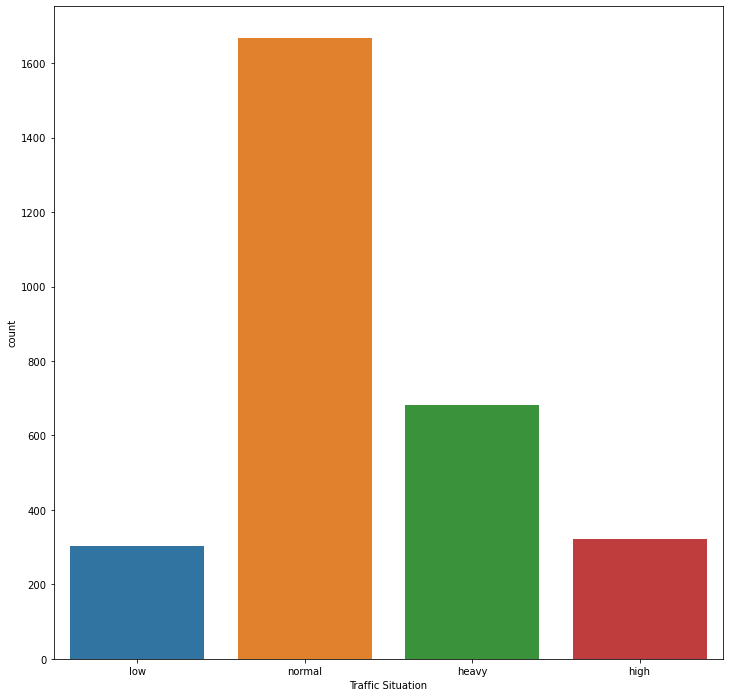

In [7]:
plt.figure(figsize=(12,12))
sns.countplot(data=traffic_df, x='Traffic Situation')
plt.show()

In [8]:
# Distribution of Traffice
fig = px.pie(traffic_df, names = 'Traffic Situation', title = 'Traffic Situation Distribution',
            color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text = 'Traffic Situation Distribution', title_x=0.5, template='plotly_white')
fig.show()

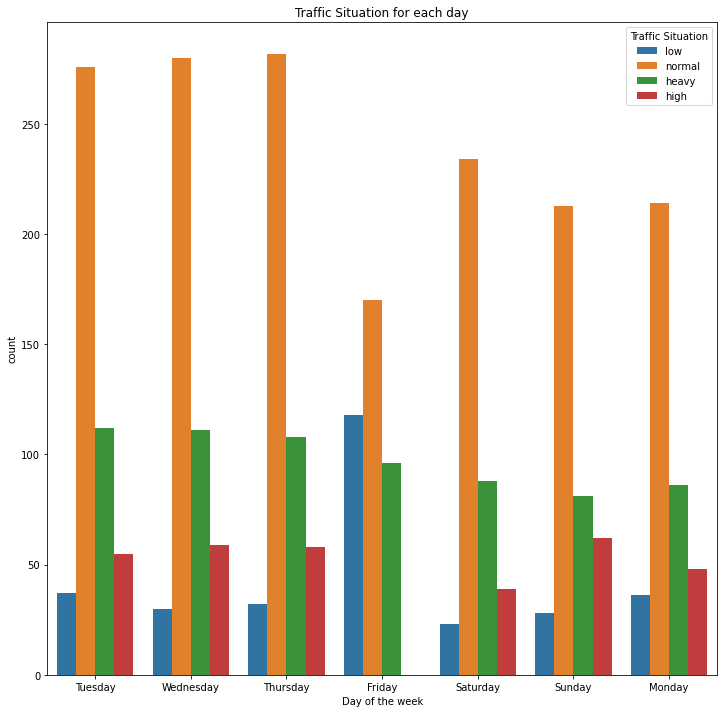

In [9]:
plt.figure(figsize=(12,12))
sns.countplot(data=traffic_df,x='Day of the week',hue='Traffic Situation')
plt.title("Traffic Situation for each day")
plt.show()

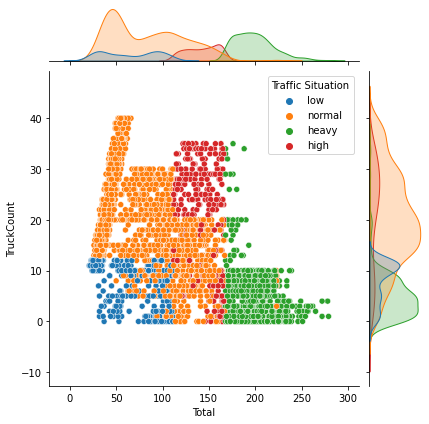

In [10]:
sns.jointplot(data = traffic_df, x = "Total", y="TruckCount", 
             hue = "Traffic Situation")

<AxesSubplot:xlabel='CarCount', ylabel='Count'>

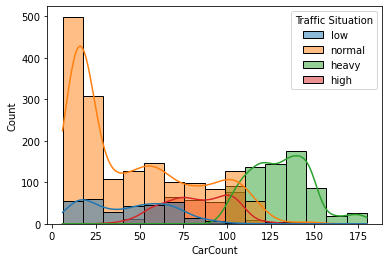

In [11]:
sns.histplot(data = traffic_df, x='CarCount', hue='Traffic Situation',
            kde=True)

<AxesSubplot:xlabel='BikeCount', ylabel='Count'>

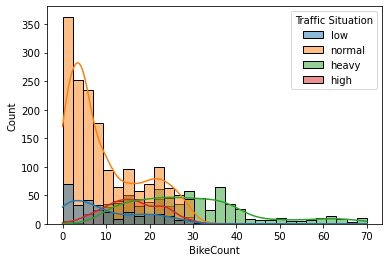

In [12]:
sns.histplot(data = traffic_df, x='BikeCount', hue='Traffic Situation',
            kde=True)

<AxesSubplot:xlabel='BusCount', ylabel='Count'>

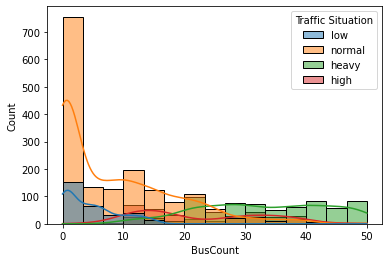

In [13]:
sns.histplot(data = traffic_df, x='BusCount', hue='Traffic Situation',
            kde=True)

<AxesSubplot:xlabel='TruckCount', ylabel='Count'>

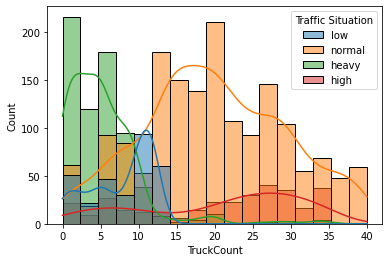

In [14]:
sns.histplot(data = traffic_df, x='TruckCount', hue='Traffic Situation',
            kde=True)

<AxesSubplot:xlabel='Total', ylabel='Count'>

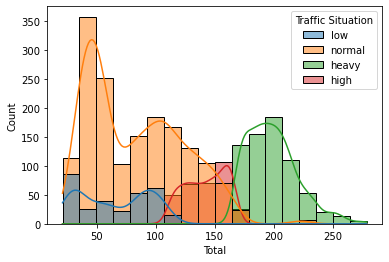

In [15]:
sns.histplot(data = traffic_df, x='Total', hue='Traffic Situation',
            kde=True)

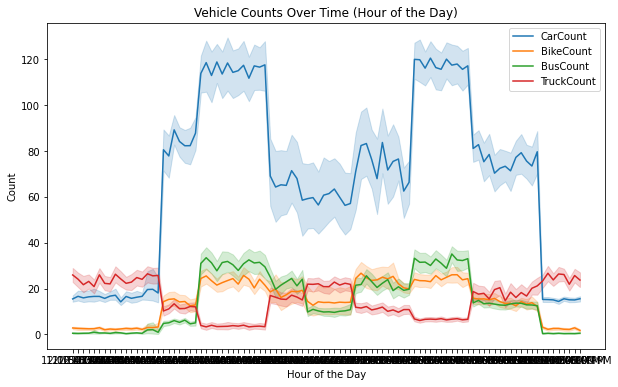

In [16]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=traffic_df, x='Time', y='CarCount', label='CarCount')
sns.lineplot(data=traffic_df, x='Time', y='BikeCount', label='BikeCount')
sns.lineplot(data=traffic_df, x='Time', y='BusCount', label='BusCount')
sns.lineplot(data=traffic_df, x='Time', y='TruckCount', label='TruckCount')
plt.title('Vehicle Counts Over Time (Hour of the Day)')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.legend()
plt.show()


In [17]:
x=traffic_df.drop(['Time', 'Traffic Situation'], axis=1)
y=traffic_df['Traffic Situation']

In [18]:
x.head()

Date Day of the week  CarCount  BikeCount  BusCount  TruckCount  Total
0    10         Tuesday        31          0         4           4     39
1    10         Tuesday        49          0         3           3     55
2    10         Tuesday        46          0         3           6     55
3    10         Tuesday        51          0         2           5     58
4    10         Tuesday        57          6        15          16     94

### Convert categorical data into numerical form

#### Convert Traffic Situation into a numerical form

In [22]:
traffic_df.head()

Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   

   TruckCount  Total  Traffic Situation  
0           4     39                  0  
1           3     55                  0  
2           6     55                  0  
3           5     58                  0  
4          16     94                  1

In [24]:
traffic_map = {'low':0, 'normal':1, 'heavy':2, 'high':3}
traffic_df['Traffic Situation'] = traffic_df['Traffic Situation'].replace(traffic_map)

traffic_df.head()

Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   

   TruckCount  Total  Traffic Situation  
0           4     39                  0  
1           3     55                  0  
2           6     55                  0  
3           5     58                  0  
4          16     94                  1

#### Convert Day of the Week into numerical form

In [26]:
day_map = {'Monday':1,'Tuesday':2, 'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
traffic_df['Day of the week'] = traffic_df['Day of the week'].replace(day_map)

traffic_df.head()

Time  Date  Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10                2        31          0         4   
1  12:15:00 AM    10                2        49          0         3   
2  12:30:00 AM    10                2        46          0         3   
3  12:45:00 AM    10                2        51          0         2   
4   1:00:00 AM    10                2        57          6        15   

   TruckCount  Total  Traffic Situation  
0           4     39                  0  
1           3     55                  0  
2           6     55                  0  
3           5     58                  0  
4          16     94                  1

#### Create a copy of our dataframe

In [29]:
traffic_ml = traffic_df.copy()

#### Extract specific time-related data from the time column into seperate columns

In [30]:
traffic_ml['hour'] = pd.to_datetime(traffic_ml['Time']).dt.hour
traffic_ml['minute'] = pd.to_datetime(traffic_ml['Time']).dt.minute

#Temp column for AM/PM
traffic_ml['Temp'] = traffic_ml['Time'].apply(lambda x: x.split(' ')[1]) 
traffic_ml['AM/PM'] = traffic_ml['Temp'].replace({'AM': 0, 'PM': 1})
traffic_ml = traffic_ml.drop(columns = ['Time', 'Temp'], axis=1)
traffic_ml

Date  Day of the week  CarCount  BikeCount  BusCount  TruckCount  Total  \
0       10                2        31          0         4           4     39   
1       10                2        49          0         3           3     55   
2       10                2        46          0         3           6     55   
3       10                2        51          0         2           5     58   
4       10                2        57          6        15          16     94   
...    ...              ...       ...        ...       ...         ...    ...   
2971     9                4        16          3         1          36     56   
2972     9                4        11          0         1          30     42   
2973     9                4        15          4         1          25     45   
2974     9                4        16          5         0          27     48   
2975     9                4        14          3         1          15     33   

      Traffic Situation  hour  minute  AM/PM  
0                     0     0       0      0  
1                     0     0      15      0  
2                     0     0      30      0  
3                     0     0      45      0  
4                     1     1       0      0  
...                 ...   ...     ...    ...  
2971                  1    22      45      1  
2972                  1    23       0      1  
2973                  1    23      15      1  
2974                  1    23      30      1  
2975                  1    23      45      1  

[2976 rows x 11 columns]

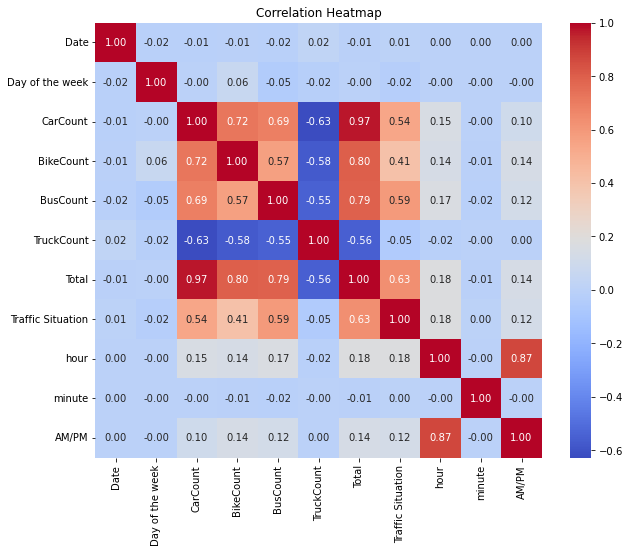

In [31]:
plt.figure(figsize=(10, 8))
correlation_matrix = traffic_ml.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#### Initial Thoughts on Correlation Heatmap

The correlation heatmap shows the correlation between all the variables in our traffic dataset.  A strong correlation is shown in red, whereas a strong negative correlation is shown in blue. 

Key observations:
- CarCount and BikeCount have a strong correlation indicating they tend to increase or decrease together
- CarCount, BikeCount, and BusCount all have a strong negative correlation to the traffic situation. This suggests that increased traffic is associated with lower traffic conditions.

### Hypothesis

Based on the exploratory data analysis presented above, we can hypothesize that:

- Traffic volume varies significantly by the time of day and day of the week
- Certain vehicle types might dominate traffic at specific times
- The correlation between differnt vehicle types may indicate patterns in traffic flow
- Predicting traffic situations based on vehicle counts

### Split the Dataset into a test and a training set

In [32]:
X= traffic_ml[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total','hour', 'minute', 'AM/PM']]

y= traffic_ml['Traffic Situation'].values

In [33]:
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=0)

### Feature Scaling

In [34]:
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

### Model Creation

In [37]:
mod1 = LogisticRegression()
mod2 = RandomForestClassifier()
mod3 = SVC(probability=True)
mod4 = XGBClassifier()
mod5 = AdaBoostClassifier()

### Voting Classifier

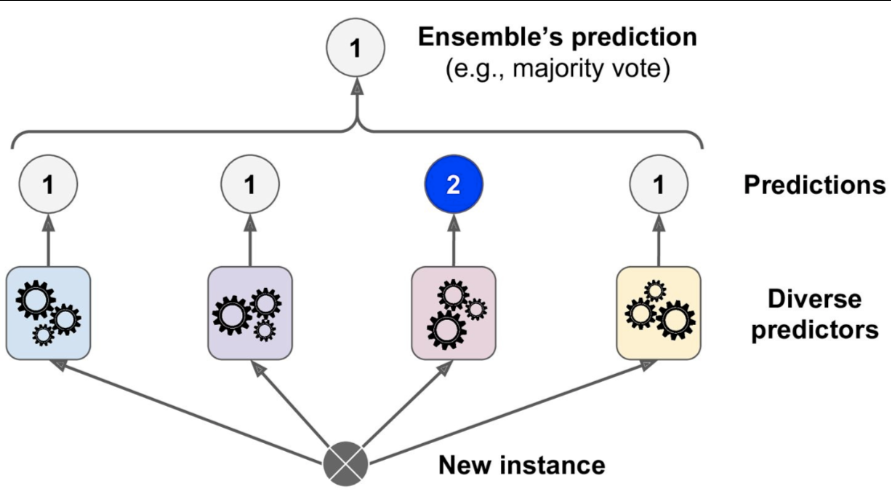

Use the Voting classifier to determine our predictors

In [38]:
voting_class = VotingClassifier(estimators = [('lr',mod1),('rf',mod2),('svc',mod3),
                                          ('xgb',mod4),('ada',mod5)], voting = 'hard')
voting_class.fit(train_X, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None...
                                            importance_type=None,
                                            interaction_constraints=None,
                    

### Accuracy of Voting Classifier

In [45]:
voting_predict = voting_class.predict(test_X)
accuracy = accuracy_score(test_y, voting_predict)

accuracy

0.9446308724832215

In [46]:
for mod, label in zip([mod1,mod2,mod3,mod4,mod5], ['lr', 'rf', 'svc', 'xgb', 'ada']):
    scores = cross_val_score

### Cross-validation

In [47]:
for mod, label in zip([mod1,mod2,mod3,mod4,mod5], ['lr', 'rf', 'svc', 'xgb', 'ada']):
    scores = cross_val_score(mod, train_X, train_y, scoring='accuracy', cv=5)
    print('Accuracy: ', (scores.mean(), label))

Accuracy:  (0.8991596638655462, 'lr')
Accuracy:  (0.9945378151260504, 'rf')
Accuracy:  (0.9147058823529411, 'svc')
Accuracy:  (0.9983193277310924, 'xgb')
Accuracy:  (0.5609243697478992, 'ada')


### Initial Thoughts

We can see that the performance of these models were very good, but some models outperformed others.

- We have a 99.4% accuracy rating with the Random Forest model
- We have a 99.8% accuracy rating with the XGBoost model
- We have a 56% accuracy rating with the AdaBoost model

#### Run the Random Forest Model alone

In [49]:
model1 = RandomForestClassifier()
model1.fit(train_X, train_y)

model1_pred = model1.predict(test_X)
accuracy = accuracy_score(test_y, model1_pred)
accuracy

0.9949664429530202

#### Run the XGBoost alone

In [50]:
model2 = XGBClassifier()
model2.fit(train_X, train_y)

model2_pred = model2.predict(test_X)
accuracy = accuracy_score(test_y, model2_pred)
accuracy

1.0

#### Run a random forest classifier with 100 estimators

#### Confusion Matrix

- XGBoost model and random forest model are both nearly 100% accuracy, which is a sign for potential overfitting
- Need to validate the model with cross validation

In [61]:
# Train RandomForestClassifier model
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model3.fit(train_X, train_y)

model3_pred = model3.predict(test_X)
accuracy = accuracy_score(test_y, model3_pred)
print("Confusion Matrix:\n", confusion_matrix(test_y, model3_pred))
print("Classification Report:\n", classification_report(test_y, model3_pred))
print("Accuracy Score:", accuracy_score(test_y, model3_pred))

Confusion Matrix:
 [[ 64   0   0   0]
 [  0 331   2   1]
 [  0   0 138   0]
 [  0   0   0  60]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      0.99      1.00       334
           2       0.99      1.00      0.99       138
           3       0.98      1.00      0.99        60

    accuracy                           0.99       596
   macro avg       0.99      1.00      1.00       596
weighted avg       1.00      0.99      0.99       596

Accuracy Score: 0.9949664429530202


## Conclusion

The overall accuracy of the model is nearly 99.4%, which indicates that it correctly predicted 99.4% of the traffic situations in the testing set.  

The precision, recall, and F1-Score for each class are all high.  This suggests the model is able to accurately identify and predict different traffic situations.  

This project has provided critial insights into traffic patterns, highlighting peak congestion times and the impact of external factors such as weather or road conditions.  The overall accuracy of these models suggest that we could have an overfitting issue, therefore, if we could get more features and data, we could produce a more effective model. 